# 3-JijModeling with OpenJij

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/en/003-PyQUBO_2_OpenJij.ipynb)

In this chapter, first we explain how to write mathmatical model with JijModeling. After that, we explaint how to convert the model to QUBO by using JijModeling Transpiler and run Simulated Annealing with OpenJij.
We solve "Creek Coverage Problem" as an example.

Please check document for more detail explanation about JijModeling and JijModeling Transpiler.

We can install `jijmodeling` with the following command using `pip`  

In [1]:
!pip install jijmodeling

You should consider upgrading via the '/home/hiromichi/.pyenv/versions/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


## Formulation of QUBO with JijModeling

JijModeling is a intuitive modeling library for fomulating mathmatical model and we can convert mathmatical model to QUBO easily. In the previous chapters, we have shown the case without JijModeling, so we had to formulate QUBO, then expand the expressions ourselves and put them into the Python script. However, we can eliminate that hassles with JijModeling.

JijModeling is a handy library that can help us reduce the computational and implementation errors in our QUBO and Ising model transformations.

Let us solve the Creek Coverage Problem as as example.

For more details of this problem, see also [here (T-Wave: creek coverage problem (only Japanese))](https://qard.is.tohoku.ac.jp/T-Wave/?p=434).

We introduce the formulation of the creek coverage problem as a mathmatical model.

This problem is whethre the graph $G=(V, E)$ can be covered by $n$ creeks.

The mathmatical model of this problem is

$$H =  \sum^n_{i=1}\left[
\frac{1}{2}\left(-1+\sum_{v \in V} x_{v,i}\right)\sum_{v \in V} x_{v, i} 
- \sum_{(u, v)\in E} x_{u,i} x_{v, i}\right]$$
$$\mathrm{s.t.\  }\quad  \sum^n_{i=1} x_{v, i} = 1\quad \mathrm{forall}\ v$$


Here, $x_{v,i}$ is binary variable and if vertex $v$ is colored by $i$th color, then $x_{v,i} = 1$.
The first term is Objective function which shows how close the split subgraph is to creek (complete graph)
Constraint is that only one color is painted on each vertex.
Both term must be zero. However, we treat the first term as a penalty term, and second as a cost(objective function).

The QUBO of this model as follows.

$$H = A\sum_v \left(1-\sum^n_{i=1} x_{v, i}\right)^2 
+ B \sum^n_{i=1}\left[
\frac{1}{2}\left(-1+\sum_{v \in V} x_{v,i}\right)\sum_{v \in V} x_{v, i} 
- \sum_{(u, v)\in E} x_{u,i} x_{v, i}\right]$$

Normally, we have write down QUBO model to use Ising optimization, however, we do not need to do so if you use JijModeling.

We give the Graph and the number of creek $n$ as follows in this time.

In [68]:
# set the number of vertex
N_VER = 8
# set the number of colors
N_COLOR = 3
# set the graph. define them which vertices are connected to each other
edges = [[0,1], [0,2], [1,2], [5,6], [2,3], [2,5], [3,4], [5,7], [7, 6]]

### Formulation with JijModeling

We import JijModeling.

In [69]:
import jijmodeling as jm

At First, we prepare variables for representing mathmatical model. We set an array of variables using `Array`.
In this time, we need the number of (N_VER) x (N_COLOR), therefore we set `shape` argument as follows.

In [70]:
problem = jm.Problem('creek')

N = jm.Placeholder('N')
V = jm.Placeholder('V')
E = jm.Placeholder('E',dim = 2)
x = jm.Binary('x', shape=(V,N))
i = jm.Element('i',(0,N))
v = jm.Element('v',(0,V))
e = jm.Element('e',E)

objective = jm.Sum(i, 1/2 * ( -1 + jm.Sum(v,x[v,i]) ) * jm.Sum(v,x[v,i]) - jm.Sum(e,x[e[0],i] * x[e[1],i]))
problem += objective
constraint = jm.Constraint("onehot",jm.Sum(i,x[v,i]) == 1,forall= v)
problem += constraint
problem

We can write the mathmatical model simple way.

Next, we need to prepare the instance data for Placeholder value.

In [71]:
instance_data = {'N':N_COLOR,'V':N_VER,'E':edges }

We finish to prepare the mathmatical model and instance data.

### Converting mathmatical model to QUBO
first we need to import transpiler function to create QUBO from mathmatical model.

In [72]:
from jijmodeling.transpiler.pyqubo.to_pyqubo import to_pyqubo

In [73]:
pyq_obj, pyq_cache = to_pyqubo(problem, instance_data,fixed_variables={})

`to_pyqubo()` creates pyqubo object (`pyq_obj`) and the information of the relationship between pyqubo object and mathmatical model is in `pyq_cache`.
Plaese see the Documentation of JijModelingTranspiler for more detail information about `to_pyqubo()`.

We can easily converted to QUBO (Python dictionary type) with `pyq_obj.compile().to_qubo()`.

In OpenJij and D-Wave Ocean, QUBO is assumed to be represented by a Python dictionary type.

We can run it on each solver by `.compile`.

In [74]:
# compile this model
qubo, offset = pyq_obj.compile().to_qubo(feed_dict = {'onehot':1.0})

`qubo` is set to QUBO and `offset` is set to the constant that appears when it is converted to QUBO.

## Run with OpenJij

Let's use OpenJij to solve creek coverage problem.

In this tutorial, we only use Simulated Annealing(SA) solver, however we can also run Simulated Quantum Annealing(SQA) as same way as SA.

In [75]:
# use SA on neal
import openjij as oj
sampler = oj.SASampler()
response = sampler.sample_qubo(qubo)

`.first.sample` extracts the lowest energy of all derived solutions.

In [76]:
print(response.first.sample)

{'x[]0_0': 0, 'x[]0_1': 0, 'x[]0_2': 1, 'x[]1_0': 0, 'x[]1_1': 0, 'x[]1_2': 1, 'x[]2_0': 0, 'x[]2_1': 0, 'x[]2_2': 1, 'x[]3_0': 1, 'x[]3_1': 0, 'x[]3_2': 0, 'x[]4_0': 1, 'x[]4_1': 0, 'x[]4_2': 0, 'x[]5_0': 0, 'x[]5_1': 1, 'x[]5_2': 0, 'x[]6_0': 0, 'x[]6_1': 1, 'x[]6_2': 0, 'x[]7_0': 0, 'x[]7_1': 1, 'x[]7_2': 0}


We can use `.decode` method to see the result more pretty.

In [77]:
result = pyq_cache.decode(response)
result.record.solution

{'x': [(([3, 4, 5, 6, 7, 0, 1, 2], [0, 0, 1, 1, 1, 2, 2, 2]),
   [1, 1, 1, 1, 1, 1, 1, 1],
   ())]}

The solution is in the COO format. It means that the solution array containts only indexed with a value of 1.
This format is convinient to see the result becuase normally we only know which value is 1 or not.
Let us see the result.

In [80]:
import networkx as nx
import matplotlib.pyplot as plt

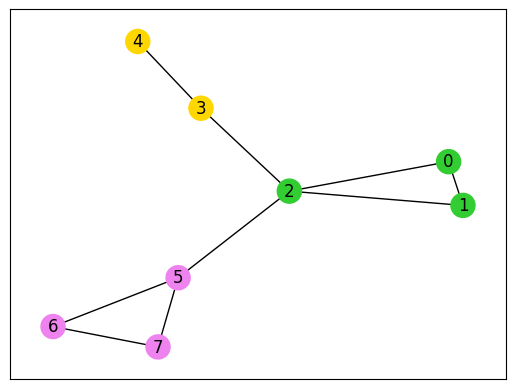

In [81]:
# initialize vertex color list
node_colors = [-1] * N_VER
# set color list for visualization
colorlist = ['gold', 'violet', 'limegreen', 'darkorange']
# set vertex color list
for node_num,class_num in zip(*result.record.solution['x'][0][0]):
    node_colors[node_num] = colorlist[class_num]
# make figure
fig = plt.figure()
G = nx.Graph()
G.add_nodes_from(range(N_VER))
G.add_edges_from(instance_data["E"])
nx.draw_networkx(G, node_color=node_colors, with_labels=True)

The graph is divided by each creeks.

We can check the energy and objective value by using `result.evaluation`

In [82]:
result.evaluation

Evaluation(energy=[-8.0], objective=[0.0], constraint_violations={'onehot': [0.0]}, penalty=[{}])

## Conclusion

We learned how to formulate it using JijModeling and how it works with OpenJij.

Procedures are as follows.

1. Write down the mathmatical model by using JijModeling
2. Convert mathmatical model to QUBO by using JijModeling Transpiler
3. compile QUBO and convert it to a dictionary type
4. solve optimization problems using OpenJij's solver such as `SASampler()`
5. decode solution by using `decode`.

JijModeling is useful and powerful tool for formulationg and JijModeling Transpiler provides easy interface to convert mathmatical model to QUBO. 
When we use in conjunction with OpenJij, which provides a variety of solvers, it provides comfortable development experience.